## Characer Level Sequence-to-Sequence Neural Translation Model

Ref: https://www.kaggle.com/shujunge/lstm-seq2seq-with-keras

In [0]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on (of the nearly 150,000 examples)
# Path to the data txt file on disk.
data_path = 'fra.txt'


In [0]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
#     lines = f.readlines()

In [8]:
lines[:10]

['Go.\tVa !',
 'Hi.\tSalut !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!']

In [0]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [0]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [11]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


## Turn the sentences into 3 Numpy arrays,

In [0]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# Input Sequences: Padded to a maximum length of 16 characters 
# with a vocabulary of 69 different characters (10000, 16, 69).
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# Output Sequences: Padded to a maximum length of 59 characters 
# with a vocabulary of 93 different characters (10000, 59, 93).
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [0]:
# The training data is framed such that the input for the model 
# is comprised of one whole input sequence of English characters 
# and the whole output sequence of French characters. 
# The output of the model is the whole sequence of French characters, 
# but offset forward by one time step.

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be offset by one timestep
            # and will not include the start character.
            # decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
            decoder_target_data[i, t - 1, target_token_index[char]] = 1

In [14]:
np.argmax(encoder_input_data[0], axis = 1)

array([25, 57,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [15]:
[input_characters[25], input_characters[57], input_characters[8]]

['G', 'o', '.']

In [16]:
np.argmax(decoder_input_data[0], axis = 1)

array([ 0, 42, 44,  2,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [0]:
[target_characters[0], target_characters[42], target_characters[44], 
 target_characters[2], target_characters[3], target_characters[1]]

['\t', 'V', 'a', ' ', '!', '\n']

In [0]:
np.argmax(decoder_target_data[0], axis = 1)

array([42, 44,  2,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [38]:
[target_characters[42], target_characters[44], 
 target_characters[2], target_characters[3], target_characters[1]]

['V', 'a', ' ', '!', '\n']

## Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. 

The model is divided into two sub-models: 
- the encoder responsible for outputting a fixed-length encoding of the input English sequence, and
- the decoder responsible for predicting the output sequence, one character per output time step.

The LSTM layer in the encoder is defined with the return_state argument set to True.

This returns the hidden state output returned by LSTM layers generally, as well as the hidden and cell state for all cells in the layer. 

These are used when defining the decoder.

In [17]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

The decoder input is defined as a sequence of French character one-hot encoded to binary vectors with a length of num_decoder_tokens.

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

The LSTM layer is defined to both return sequences and state. The final hidden and cell states are ignored and only the output sequence of hidden states is referenced.

Importantly, the final hidden and cell state from the encoder is used to initialize the state of the decoder. This means every time that the encoder model encodes an input sequence, the final internal states of the encoder model are used as the starting point for outputting the first character in the output sequence. This also means that the encoder and decoder LSTM layers must have the same number of cells, in this case, 256.

In [0]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

A Dense output layer is used to predict each character. This Dense is used to produce each character in the output sequence in a one-shot manner, rather than recursively, at least during training. This is because the entire target sequence required for input to the model is known during training.

In [0]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 69)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 333824      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_3[0][0]                    
                                                                 lstm_1[0][1]               

In [25]:
print("encoder_input_data shape:",encoder_input_data.shape)
print("decoder_input_data shape:",decoder_input_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_input_data shape: (10000, 16, 69)
decoder_input_data shape: (10000, 59, 93)
decoder_target_data shape: (10000, 59, 93)


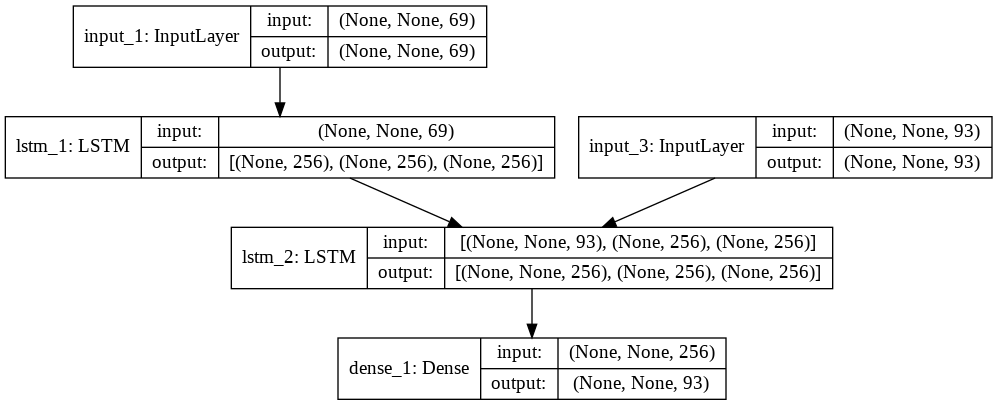

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

Note that the encoder LSTM does not directly pass its outputs as inputs to the decoder LSTM; as noted above, the decoder uses the final hidden and cell states as the initial state for the decoder.

Also note that the decoder LSTM only passes the sequence of hidden states to the Dense for output, not the final hidden and cell states as suggested by the output shape information.

In [0]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 62s 8ms/step - loss: 0.9172 - val_loss: 0.9530
Epoch 2/100
8000/8000 [==============================] - 61s 8ms/step - loss: 0.7270 - val_loss: 0.7765
Epoch 3/100
8000/8000 [==============================] - 61s 8ms/step - loss: 0.6177 - val_loss: 0.6846
Epoch 4/100
8000/8000 [==============================] - 61s 8ms/step - loss: 0.5625 - val_loss: 0.6377
Epoch 5/100
8000/8000 [==============================] - 60s 8ms/step - loss: 0.5213 - val_loss: 0.6085
Epoch 6/100
8000/8000 [==============================] - 60s 8ms/step - loss: 0.4904 - val_loss: 0.5733
Epoch 7/100
8000/8000 [==============================] - 60s 8ms/step - loss: 0.4646 - val_loss: 0.5522
Epoch 8/100
8000/8000 [==============================] - 60s 8ms/step - loss: 0.4427 - val_loss: 0.5416
Epoch 9/100
8000/8000 [==============================] - 60s 8ms/step - loss: 0.4239 - val_loss: 0.5235
Epoch 10/100
800

## Decode sentences / inference (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

Once the defined model is fit, it can be used to make predictions. Specifically, output a French translation for an English source text.

The model defined for training has learned weights for this operation, but the structure of the model is not designed to be called recursively to generate one character at a time.

Instead, new models are required for the prediction step, specifically a model for encoding English input sequences of characters and a model that takes the sequence of French characters generated so far and the encoding as input and predicts the next character in the sequence.

Defining the inference models requires reference to elements of the model used for training in the example. Alternately, one could define a new model with the same shapes and load the weights from file.

The encoder model is defined as taking the input layer from the encoder in the trained model (encoder_inputs) and outputting the hidden and cell state tensors (encoder_states).

In [0]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

The decoder requires the hidden and cell states from the encoder as the initial state of the newly defined encoder model. Because the decoder is a separate standalone model, these states will be provided as input to the model, and therefore must first be defined as inputs

In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

They can then be specified for use as the initial state of the decoder LSTM layer.

In [0]:
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

Both the encoder and decoder will be called recursively for each character that is to be generated in the translated sequence.

On the first call, the hidden and cell states from the encoder will be used to initialize the decoder LSTM layer, provided as input to the model directly.

On subsequent recursive calls to the decoder, the last hidden and cell state must be provided to the model. These state values are already within the decoder; nevertheless, we must re-initialize the state on each call given the way that the model was defined in order to take the final states from the encoder on the first call.

Therefore, the decoder must output the hidden and cell states along with the predicted character on each call, so that these states can be assigned to a variable and used on each subsequent recursive call for a given input sequence of English text to be translated.

In [0]:
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

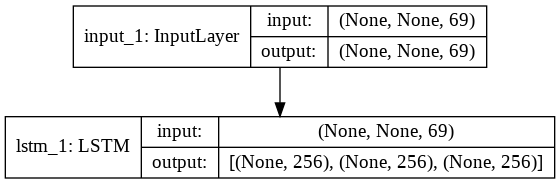

In [36]:
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)

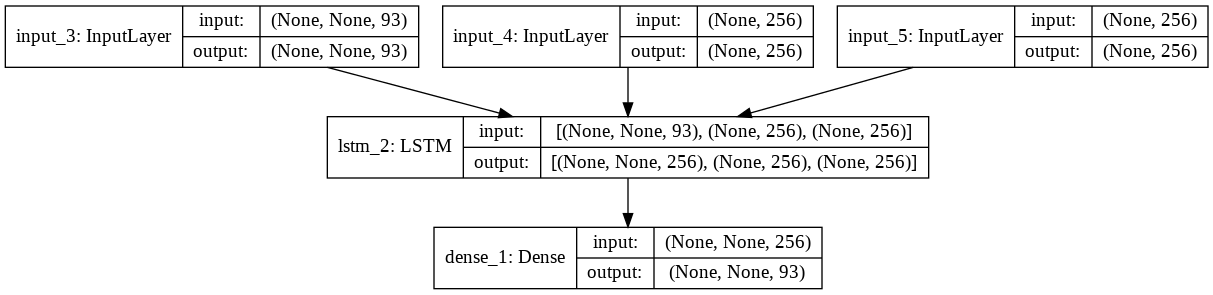

In [37]:
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

The decoder shows the three inputs required to decode a single character in the translated sequence, the encoded translation output so far, and the hidden and cell states provided first from the encoder and then from the output of the decoder as the model is called recursively for a given translation.

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
# encoder_input_data

In [0]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Sortez !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: I see.
Decoded sentence: Je